# ORC

### Example 2: RC Background

The purpose of this notebook is to provide a broad introduction to reservoir computing (RC) by walking through the creation of an RC model within the ORC framework. RC was initially proposed independently by Maas, Natschläger, and Markram [1], and Jaeger [2] in the early 2000s, largely as a means of avoiding issues with training recurrent neural networks (RNNs) via backpropagation and gradient descent. Since then, the field of RC has exploded, introducing many RC inspired architectures and new applications of RC approaches.

One of the central premises of ORC is that the vast majority of RC architectures can be decomposed into three components: an embedding that lifts a low-dimensional input signal $u_t$ to a high-dimensional space, a driver that propagates a high-dimensional latent state $r_t$, and a readout that maps the latent state back to a lower dimensional signal $\hat y_t$. More concretely, we can typically represent the embedding, driver, and readout as functions<sup>1</sup>
$$f_{E} : \mathbb R^{N_u} \to \mathbb R^{N_r}  \quad \text{with} \quad \tilde u_{t} = f_{E}(u_t),\quad \text{(embedding)}$$
$$f_{R} : \mathbb R^{N_r} \times \mathbb R^{N_r} \to \mathbb R^{N_r} \quad \text{with} \quad r_{t+1} = f_R(r_t, \tilde u_t), \quad \text{(driver)}$$
and
$$f_{O} : \mathbb R^{N_y} \to \mathbb R^{N_r} \quad \text{with} \quad \hat y_{t} = f_O(r_t). \quad \text{(readout)}$$

We'll call $N_u$ the input dimension, $N_r$ the reservoir dimension, and $N_y$ the output dimension. RC makes the assumption that if the reservoir dimension is sufficiently large ($N_r \gg N_u$) and the dynamics of the driver are sufficiently "expressive," then the parameters/weights of both the embedding and driver can be set independent of any training data; only the readout layer is trained. This greatly simplifies the training of an RC in comparison to RNNs as it completely avoids backpropagation through time. It also allows for the implementation of a wider variety of embeddings and drivers, including physical implementations of RC.

Throughout the rest of this notebook, we'll illustrate how ORC can be used to instantiate and train a RC for forecasting with user-defined embedding, driver, and readout.

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp

import orc

### Defining an embedding

By far, the most common choice for embedding function is to assume the form $f_{E}(u) = W_{E} u$ where $W_{E} \in \mathbb R ^{N_r \times N_u}$ with entries drawn independently according to some distribution. However, to illustrate that ORC allows for a very broad range of embeddings, we'll take $f_{E}$ to be a two-layer MLP with an ELU activation function. To do so, we'll inherit from `orc.embeddings.EmbedBase`, which expects us to specify an input dimension `in_dim`, a reservoir dimension `res_dim`, and define a method `embed` that maps from `in_dim` to `res_dim`. 

In [2]:
class ELUEmbedding(orc.embeddings.EmbedBase):

    W1: jnp.ndarray # weight matrix for first layer of ELU MLP
    W2: jnp.ndarray # weight matrix for second layer of ELU MLP
    b1: jnp.ndarray # bias for first layer of ELU MLP
    b2: jnp.ndarray # bias for second layer of ELU MLP

    def __init__(self, in_dim, res_dim, seed=0):
        super().__init__(in_dim=in_dim, res_dim=res_dim)
        rkey = jax.random.key(seed)
        W1key, W2key, b1key, b2key = jax.random.split(rkey, 4)
        # random initialization of parameters of ELU MLP
        self.W1 = jax.random.normal(W1key, shape=(res_dim // 2, in_dim)) / jnp.sqrt((res_dim // 2) * in_dim)
        self.W2 = jax.random.normal(W2key, shape=(res_dim, res_dim // 2))/ jnp.sqrt(res_dim * (res_dim // 2))
        self.b1 = jax.random.normal(b1key, shape=(res_dim // 2)) / jnp.sqrt(res_dim // 2)
        self.b2 = jax.random.normal(b1key, shape=(res_dim)) / jnp.sqrt(res_dim)

    def embed(self, in_state):
        in_state = self.W1 @ in_state + self.b1
        in_state = jax.nn.elu(in_state)
        in_state = self.W2 @ in_state + self.b2
        in_state = jax.nn.elu(in_state)
        return in_state


### Defining a driver
For the driver, we'll take a more standard form of $f_R$ as 
$$f_R (r_t, \tilde u_t) = \tanh (W_R r_t + \tilde u_t + \mathbf 1)$$
where $W_r \in \mathbb R^{N_r \times N_r}$ and $\mathbf 1$ is a vector of ones. In this form of RC, the spectral radius, $\rho_{SR}$ of $W_r$ often plays an important role in the performance of the network. In this case, we'll draw each entry of $W_R$ from $\mathcal U(-1,1)$ and then rescale to that $\rho_{SR} = 0.6.$ We'll inherit from `orc.drivers.DriverBase`, which expects us to specify the reservoir dimension and define the method `advance` to propagate the reservoir.

In [3]:
class Driver(orc.drivers.DriverBase):

    Wr: jnp.ndarray

    def __init__(self, res_dim, seed=0):
        super().__init__(res_dim=res_dim)
        key = jax.random.key(seed)
        Wr_unscaled = jax.random.uniform(key, shape=(res_dim, res_dim), minval=-1, maxval=1)
        max_eig = jnp.max(jnp.abs(jnp.linalg.eigvals(Wr_unscaled)))
        self.Wr = (Wr_unscaled / max_eig) * 0.6
    
    def advance(self, res_state, in_state):
        return jnp.tanh(self.Wr @ res_state + in_state + jnp.ones_like(in_state))

### Defining a readout
While there is great flexibility in the assumed form of $f_E$ and $f_R$, $f_O$ is more restricted if we want to retain the ability to train the RC with a linear regression. We'll assume the output operator is linear, that is $f_O(r_t) = W_Or_t$ where $W_O \in \mathbb R^{N_y \times N_r}$. We initialize the readout layer of our RC by subclassing `orc.readouts.ReadoutBase` and defining a `readout` method. We'll initialize $W_O$ with zeros, although the initialization won't affect training.

In [ ]:
class Readout(orc.readouts.ReadoutBase):
    res_dim: int
    out_dim: int
    W_O: jnp.ndarray
    
    def __init__(self, out_dim, res_dim):
        super().__init__(out_dim, res_dim)
        self.W_O = jnp.zeros((out_dim, res_dim))
    
    def readout(self, res_state):
        return self.W_O @ res_state

### Defining a forecaster
We're now able to combine these three components into a `Forecaster` that inherits from `orc.rc.RCForecasterBase`. 

In [5]:
# TODO: This is where things can be cleaned up a bit by a `createRC` function
class Forecaster(orc.rc.RCForecasterBase):
    driver: orc.drivers.DriverBase
    readout: orc.readouts.ReadoutBase
    embedding: orc.embeddings.EmbedBase

### Training
Now that the input, driver, and readout functions are defined and can be pacakged into a `Forecaster` object, we can turn to the training procedure for the model. For some example data, we'll use a numerical integration of the Rossler system.

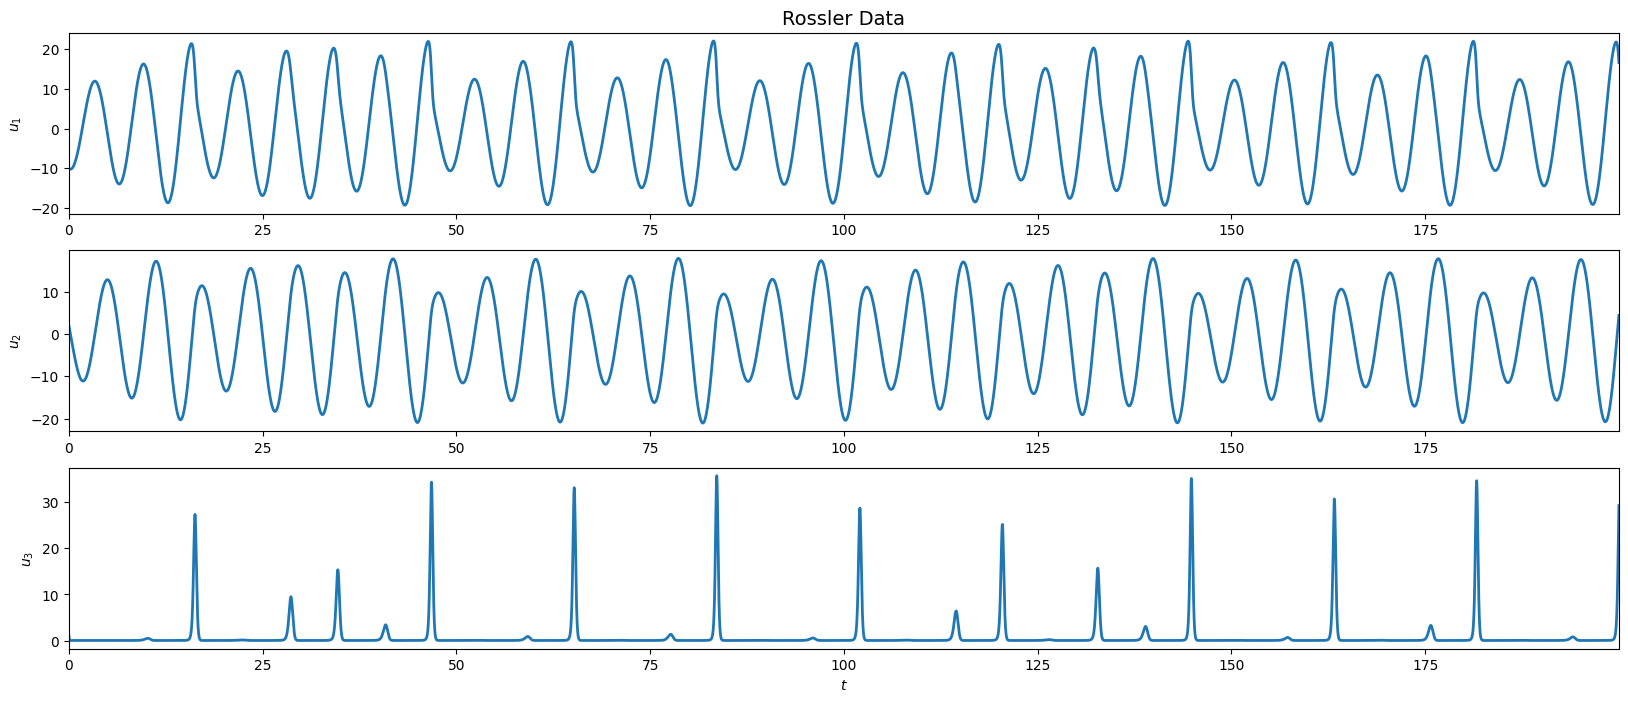

In [6]:
tN = 200
dt = 0.01
u0 = jnp.array([-10, 2, 1], dtype=jnp.float64)
U,t = orc.data.rossler(tN=tN, dt=dt, u0=u0)
split_idx = int(U.shape[0] * 0.8)
U_train = U[:split_idx]
U_test = U[split_idx:]
t_test = t[split_idx:]
orc.utils.visualization.plot_time_series(
    U,
    t,
    state_var_names=["$u_1$", "$u_2$", "$u_3$"],
    title="Rossler Data",
    x_label= "$t$",
)

The desired input (and output) dimension is that of the Rossler system, $N_y = N_u = 3$. We'll take $N_R$ = 2000 for this example.

In [7]:
Nr = 1000
Nu = 3
driver = Driver(Nr)
embedding = ELUEmbedding(Nu, Nr)
readout = Readout(Nu, Nr)
model = Forecaster(driver, readout, embedding)

Our training data can be represented in a data matrix as 
$$ 
U_{\text{data}} = \begin{bmatrix}
| & | & & |\\
u_1 & u_1 & \cdots & u_T \\
| & | &  & |
\end{bmatrix}.
$$
Now, setting $r_0 = \mathbf 0$, we can compute $r_1 = f_R(r_0, f_E(u_0))$, $r_2 = f_R(r_1, f_E(u_1))$, $\dots$, $r_T = f_R(r_{T-1}, f_E(u_{T-1}))$ to generate
$$
R_{\text{data}}\begin{bmatrix}
| & | & & |\\
r_1 & r_1 & \cdots & r_T \\
| & | &  & |
\end{bmatrix}.
$$
Learning $W_O$ now just amounts to performing a Ridge regression to satisfy $$R_{data}^T W_{O}^T = U_{data}^T.$$ In practice, we discard the first `spinup` columns of $R_{data}$ and $U_{data}$ to remove the effect of our (arbitrary) choice $r_0 = \mathbf 0.$ The ability to discard this initial transient relies on the principle of generalized synchronization and is frequently referred to as the echo state property in RC literature. 

Since we've inherited from `RCForecasterBase`, generating $R_{data}$ is easily accomplished in a single line.

In [8]:
# teacher force the reservoir
forced_seq = model.force(U_train[:-1], res_state=jnp.zeros((Nr)))

# shift the indices of the target sequence of training data
target_seq = U_train[1:]

# set transient to discard
spinup = 200

# learn W_O
# import ridge_regression
from orc.utils.regressions import ridge_regression
readout_mat = ridge_regression(forced_seq[spinup:], target_seq[spinup:], beta=1e-7)

We'd now like to update the `readout` attribute of `model` to be equal to the learned `readout_mat`. However, under the hood many ORC objects are instances of `equinox.Module`, which are immutable. Thus, we need to create a new `Forecaster` object with `readout.W_O` set to `readout_mat`. This can be done with `equinox`'s convenient `tree_at` function.

In [9]:
# define where in the forecaster model we need to update
def where(model: Forecaster):
    return model.readout.W_O
model = eqx.tree_at(where, model, readout_mat)

We're now ready to perform a forecast and evaluate our trained RC!

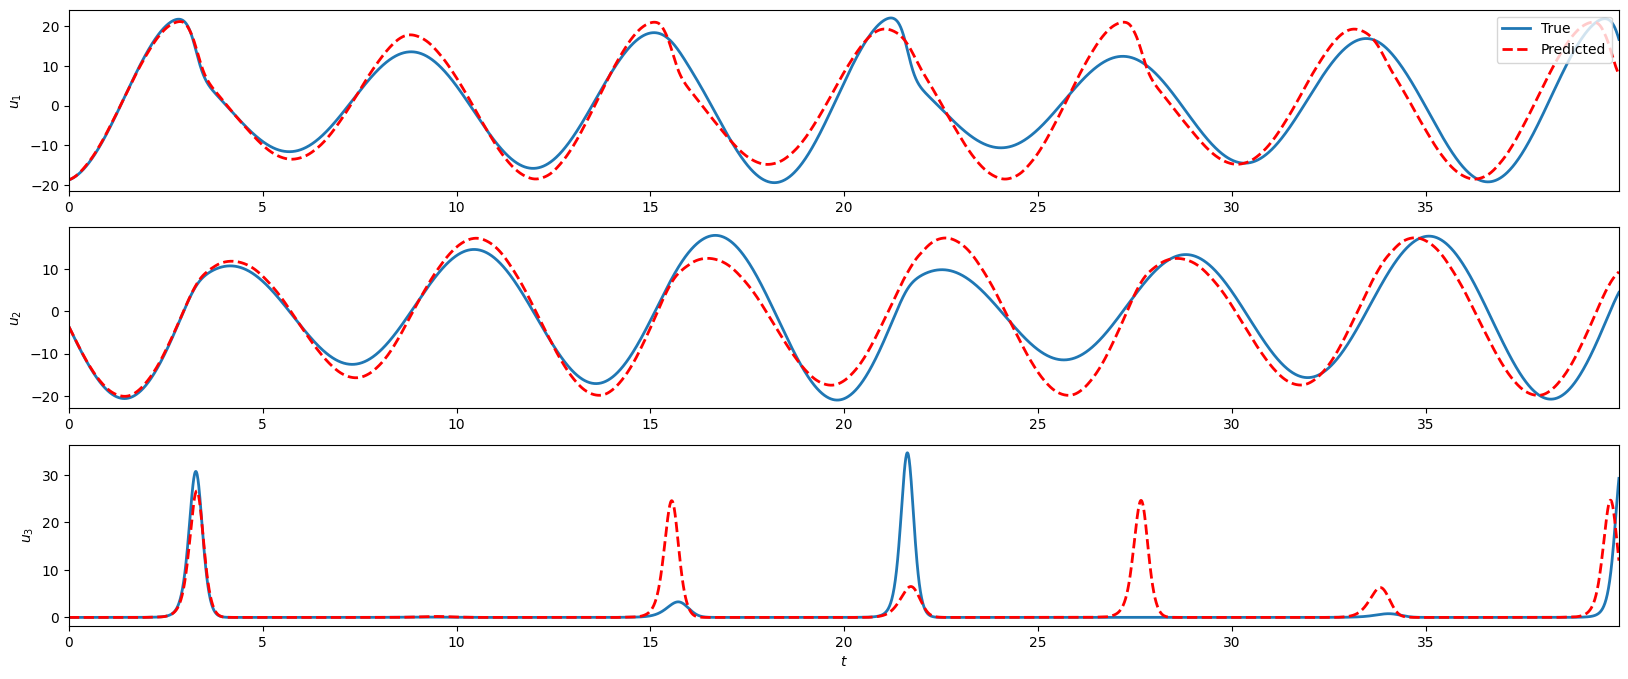

In [10]:
# perform forecast
U_pred = model.forecast_from_IC(fcast_len=U_test.shape[0], spinup_data=U_train[-spinup:])

# plot forecast
orc.utils.visualization.plot_time_series(
    [U_test, U_pred],
    (t_test - t_test[0]),
    state_var_names=["$u_1$", "$u_2$", "$u_3$"],
    time_series_labels=["True", "Predicted"],
    line_formats=["-", "r--"],
    x_label= r"$t$",
)

Let's summarize what we've seen in this notebook. We first defined an embedding, driver, and form of readout. We then packaged these together in a `Forecaster` that allowed us to easily train and evaluate the model architecture on the chaotic Rossler system. Provided that the input/output and reservoir dimensions were held fixed, we could easily switch out any of the components of the `Forecaster` for different forms/mappings (either from ORC or by defining new ones ourselves!). This modularity is a key benefit of ORC, especially when taken with the ease of defining new mappings.

### References and footnotes

[1] Maas, Natschläger, and Markram, "Real-time computing without stable states: A new framework for neural computation based on perturbations," *Neural Computation*, 2002. 

[2] Jaeger, "The “echo state” approach to analysing and training recurrent neural networks-with an erratum note," *German national research center for information technology gmd technical report*, 2001.

<sup>1</sup> There is growing interest in the field of stochastic reservoir computers, especially quantum inspired RC, where one cannot always define the embedding, driver, and readout as functions.